# Starting

In [1]:
import numpy as np
import torch
import random
import pandas as pd
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [2]:
path = '/root/.cache/kagglehub/datasets/ohagwucollinspatrick/amini-cocoa-contamination-dataset/versions/1'

In [19]:
train_df = pd.read_csv(f'{path}/Train.csv').dropna()
test_df = pd.read_csv(f'{path}/Test.csv')
sample_submission = pd.read_csv(f'{path}/SampleSubmission.csv')

In [4]:
train_df.shape, test_df.shape

((9792, 9), (1626, 9))

In [5]:
display(train_df.head()), train_df[[ 'class_id']].value_counts()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,class_id,ImagePath
0,ID_nBgcAR.jpg,healthy,1.0,75.0,15.0,162.0,195.0,2,dataset/images/train/ID_nBgcAR.jpg
1,ID_nBgcAR.jpg,healthy,1.0,58.0,1.0,133.0,171.0,2,dataset/images/train/ID_nBgcAR.jpg
2,ID_nBgcAR.jpg,healthy,1.0,42.0,29.0,377.0,349.0,2,dataset/images/train/ID_nBgcAR.jpg
3,ID_Kw2v8A.jpg,healthy,1.0,112.0,124.0,404.0,341.0,2,dataset/images/train/ID_Kw2v8A.jpg
4,ID_Kw2v8A.jpg,healthy,1.0,148.0,259.0,413.0,412.0,2,dataset/images/train/ID_Kw2v8A.jpg


(None,
 class_id
 2           4279
 1           3224
 0           2289
 Name: count, dtype: int64)

In [6]:
train_df[[ 'class']].value_counts()

class      
healthy        4280
cssvd          3241
anthracnose    2271
Name: count, dtype: int64

In [20]:
train_df.loc[train_df['class'] == 'healthy', 'class_id'] = 2
train_df.loc[train_df['class'] == 'cssvd', 'class_id'] = 1
train_df.loc[train_df['class'] == 'anthracnose', 'class_id'] = 0


In [21]:
train_df[[ 'class_id']].value_counts()

class_id
2           4280
1           3241
0           2271
Name: count, dtype: int64

In [22]:
class_mapper = {
    2 : 'healthy',
    1 : 'cssvd',
    0 : 'anthracnose'
}

In [25]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def load_image_dimensions(image_path):
    """Load image and return its width and height."""
    img = Image.open(image_path)
    return img.size

def process_bounding_boxes(label_path, img_width, img_height, class_id):
    """Process bounding boxes from the label file for a specific class."""
    widths, heights, aspect_ratios, areas = [], [], [], []
    with open(label_path, 'r') as f:
        lines = [line.strip().split() for line in f if int(line.strip().split()[0]) == class_id]

    # Convert normalized YOLO coordinates to pixel values and calculate box properties
    for line in lines:
        _, x_center, y_center, width, height = map(float, line)
        x_center, y_center = x_center * img_width, y_center * img_height
        width, height = width * img_width, height * img_height
        aspect_ratio = width / height
        area = width * height
        
        widths.append(width)
        heights.append(height)
        aspect_ratios.append(aspect_ratio)
        areas.append(area)

    return widths, heights, aspect_ratios, areas

def plot_histogram(data, ax, title, xlabel, ylabel):
    """Plot histogram of data."""
    ax.hist(data, bins=50, color='skyblue', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot_class_distribution(class_mapper, images_per_class):
    """Plot class distribution."""
    class_counts = list(images_per_class.values())
    plt.figure(figsize=(8, 6))
    plt.bar(class_mapper.values(), class_counts, color='skyblue', edgecolor='black')
    plt.title('Number of Images per Class')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

def perform_eda(path, class_mapper):
    # Variables to store data for analysis
    image_widths, image_heights, aspect_ratios = [], [], []
    bounding_box_widths, bounding_box_heights = [], []
    bounding_box_aspect_ratios, bounding_box_areas = [], []
    images_per_class = {CLASS: 0 for CLASS in class_mapper}  # Initialize class counters

    # Iterate through each class and process images
    for CLASS, cname in class_mapper.items():
        for image_file in os.listdir(os.path.join(path, "images", 'train')):
            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(path, "labels", 'train', label_file)
            image_path = os.path.join(path, "images", 'train', image_file)

            # Skip if label file does not exist
            if not os.path.exists(label_path):
                continue

            # Read image dimensions
            img_width, img_height = load_image_dimensions(image_path)
            image_widths.append(img_width)
            image_heights.append(img_height)
            aspect_ratios.append(img_width / img_height)

            # Process bounding boxes
            widths, heights, aspect_ratios_box, areas = process_bounding_boxes(
                label_path, img_width, img_height, CLASS
            )
            bounding_box_widths.extend(widths)
            bounding_box_heights.extend(heights)
            bounding_box_aspect_ratios.extend(aspect_ratios_box)
            bounding_box_areas.extend(areas)

            # Track image count per class
            images_per_class[CLASS] += 1

    # Plot image dimensions distributions
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    plot_histogram(image_widths, axes[0, 0], 'Distribution of Image Widths', 'Width', 'Frequency')
    plot_histogram(image_heights, axes[0, 1], 'Distribution of Image Heights', 'Height', 'Frequency')
    plot_histogram(aspect_ratios, axes[1, 0], 'Distribution of Aspect Ratios', 'Aspect Ratio (Width / Height)', 'Frequency')
    plot_histogram(bounding_box_widths, axes[1, 1], 'Bounding Box Width Distribution', 'Bounding Box Width', 'Frequency')
    plot_histogram(bounding_box_heights, axes[2, 0], 'Bounding Box Height Distribution', 'Bounding Box Height', 'Frequency')
    plot_histogram(bounding_box_areas, axes[2, 1], 'Bounding Box Area Distribution', 'Bounding Box Area', 'Frequency')

    plt.tight_layout()
    plt.show()

    # Plot class distribution
    plot_class_distribution(class_mapper, images_per_class)


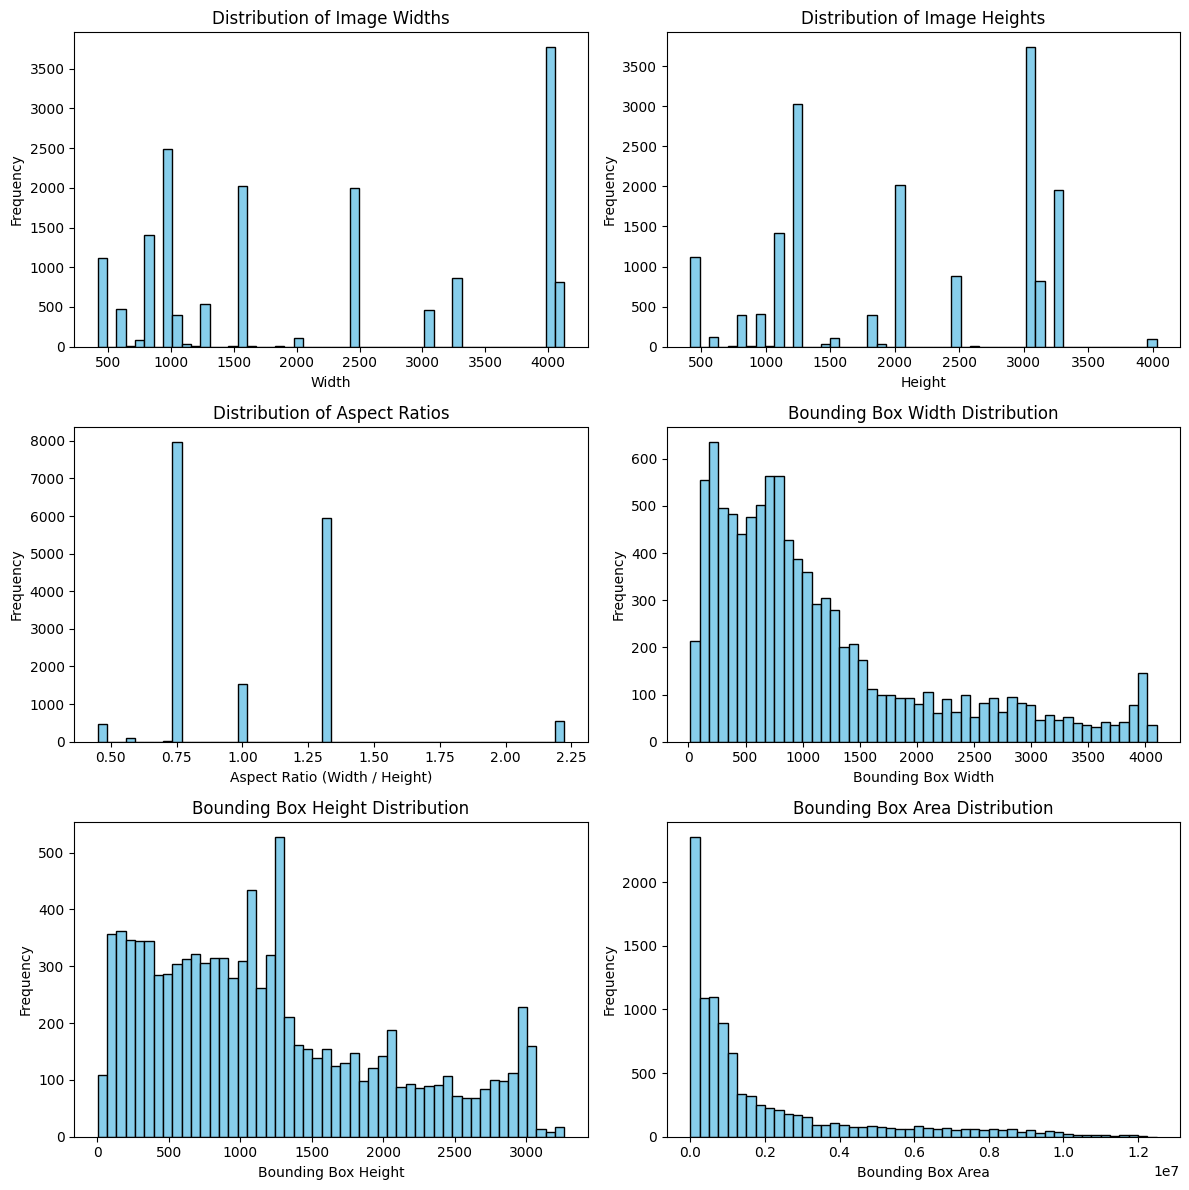

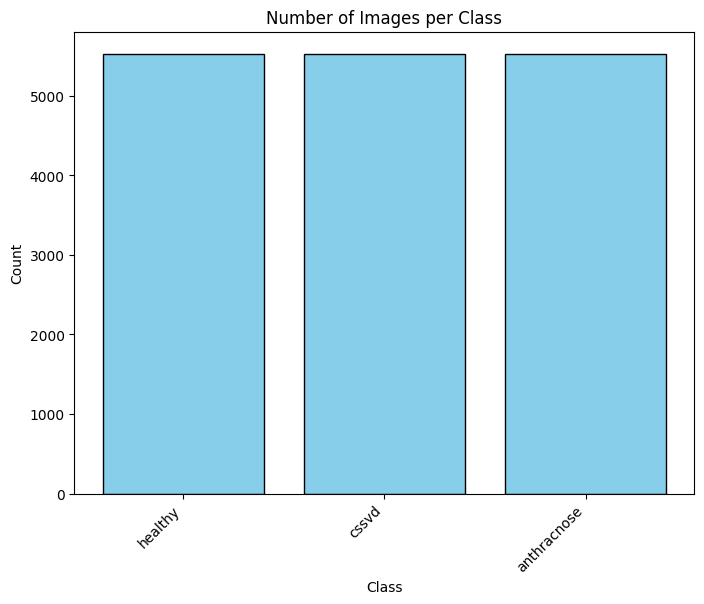

In [26]:
perform_eda(path+'/dataset', class_mapper)
